In [152]:
import matplotlib.pyplot as plt
import seaborn as sns
import time

import gym
import numpy as np
import os
import ptan

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import collections
import seaborn as sns

sns.set_style('darkgrid')

## Units

$l_n = X \ m$

$ 1 \frac{l_n}{t_n^2} := \frac{G M}{R_p^2}$

$ 1 \ t_n = \left(\frac{R_p^2 \ X \ m}{G M}\right)^{1/2}$

$ \dot{\theta} = \left(\frac{GM}{r^3}\right)^{1/2} = \frac{1}{r^{3/2}} R_p \ \frac{l_n^{1/2}}{t_n}$

$ \hat{R_p} \ l_n = R_p$

$\dot{\theta} = \frac{\hat{R_p}}{\hat{r}^{3/2}} \frac{1}{t_n}$


$1/2\dot{r}^2 + 1/2r^2 \dot{\theta}^2 + GM/r$

$\ddot{r} = r \dot{\theta}^2 - \frac{GM}{r^2}$

$\ddot{\theta} = -2 \frac{\dot{r}}{r} \dot{\theta}$

In [309]:
class OrbitalDynamicsEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    # dt_s -- is the time step in seconds.
    def __init__(self, ln_m = 1000.0, dt_s = 1.0, target_r = 2.0, thrust_gs= 1.25, verbose = False, 
                 record_history = True, record_rate = 100):
        super(OrbitalDynamicsEnv, self).__init__()
        self.record_rate = record_rate
    
        # Actions
        self.action_space = gym.spaces.Box(low=np.array([0, 100.0]), 
                                           high=np.array([100.0, 100.0]), 
                                           dtype=np.float32)
        
        # Obs (r,rdot,theta,theta_dot)
        self.observation_space = gym.spaces.Box(low=np.array([0., -10., 0.0, -10.0]), 
                                                high=np.array([10., 10., 2*np.pi, 10.0]), 
                                                dtype=np.float32)
        
        self.record_history = record_history
        
        # Newton's Gravitational Constant in SI units
        G = 6.674*10**(-11) # m^3 kg^-1 s^-2 
        planet_Mass_kg = 5.972*10**(24)
        planet_R_km = 6371.0
        planet_R_m = planet_R_km*10**3
        self.planet_R_ln = planet_R_m/ln_m
        
        # Convert to Natural Problem Units
        # tn_s = (R^2/GM*X m)^1/2 -- where all measures are in SI units
        
        tn_s = (planet_R_m**2/(G*planet_Mass_kg)*ln_m)**0.5
        
        # define the time step in seconds
        self.dts = dt_s
        # define the natural length in meters
        self.ln_m = ln_m
        # convert the time step in seconds to natural time
        self.dt = dt_s/tn_s
        
        if verbose:
            print('Units')
            print('-----')
            print('\ttime: 1 s = ', 1.0/tn_s,' tn')
            print('\tlength: 1 m = ',1/ln_m,' ln')
            print('Simulation parameters')
            print('-----')
            print('\tnatural units time step size: ',self.dt)
        
        # setting the target altitude in natural units
        self.target_r = self.planet_R_ln + target_r
        self.max_r = self.planet_R_ln + 2.0*self.target_r
        
        # solving the oribital angular velocity in natural units
        self.orbit_theta_dot = self.planet_R_ln*self.target_r**(-1.5)
        self.max_theta_dot = 10.0*self.orbit_theta_dot
        
        # solving the maxium allowable natural time to run an episode
        self.max_time = 2*np.pi/self.orbit_theta_dot
        # adding in a buffer to allow it to go a little longer
        self.max_time = 5*self.max_time
        # solving the maximum allowable steps given the max time
        self.max_steps = np.int32(np.ceil(self.max_time/self.dt))
        
        if verbose:
            print('\ttarget theta dot: ', self.orbit_theta_dot, ' 1/tn')
            print('\tmax allowable natural time: ', self.max_time, " tn = ", self.max_time*tn_s," s")
            print('\tmax allowed steps: ', self.max_steps)
            
        
        # max accleration from thrust in natural units (ln/tn^2)
        # 1 g = GM/R_planet^2 --in natural units--> 1 g = (ln^3/tn^2)/(ln^2)
        # 1 g. = 1 ln/tn^2
        self.max_thrust = thrust_gs
        self.max_o_thrust = 1.5
        
        if verbose:
            print('Policy Parameters')
            print('-----')
            max_thrust_SI = self.max_thrust*(self.ln_m)/(tn_s**2)
            # as a reference https://www.nasa.gov/pdf/466711main_AP_ST_ShuttleAscent.pdf
            # says the spaceshuttle never exceeded 3gs or ~ 30 m/s^2
            print('\tDiscrete thrust acceleration: ', self.max_thrust,' ln/tn^2 = ', max_thrust_SI,' m/s^2')
        
    def reset(self):
        # Reset the state of the environment to an initial state
        self.steps = 0
        
        # Orientation Coordinate in global coordinates
        self.orientation_rate = 0.0
        self.orientation_angle = 0.0
        
        # Translational Coordinates
        self.r = self.planet_R_ln
        self.r_dot = 0.0
        self.r_double_dot = 0.0
        
        self.theta = 0.0
        self.theta_dot = 0.0 # can change this if u want to add planetary rotation
        self.theta_double_dot = 0.0
        
        self.elapsed_time = 0.0 # elapsed sim time in natural units
        self.elapsed_time_s = 0.0 # elapsed sim time in seconds
        
        # initialize the history array
        if self.record_history:
            self.trajectory = np.array([[self.r*np.cos(self.theta), self.r*np.sin(self.theta), 
                                         self.orientation_angle]])
        
        obs = np.array([self.r, self.r_dot, self.theta, self.theta_dot])
        
        return obs
    
    # continous actions = (mean thrust, mean counter clockwise rotation thrust)
    def step(self, action):
        self.steps += 1
        
        # actions segragation
        thrust = np.clip(action[0], 0.0, self.max_thrust)
        orientation_thrust = np.clip(action[1], -self.max_o_thrust, self.max_o_thrust) 

        # Translating the actions into the planet centric coordinate system
        action_vector = thrust*np.array([np.cos(self.orientation_angle), 
                                         np.sin(self.orientation_angle)])
        
        # Apply the orientation action prior to the state propagator
        self.orientation_angle += self.orientation_rate*self.dt + 0.5*orientation_thrust*self.dt**2
        self.orientation_rate += orientation_thrust*self.dt

        # current r hat vector and theta hat vector
        r_vect = np.array([np.cos(self.theta), np.sin(self.theta)])
        theta_vect = np.array([-np.sin(self.theta), np.cos(self.theta)])
        
        # projection of actions along r and theta 
        action_along_r = np.dot(r_vect, action_vector)
        action_along_theta = np.dot(theta_vect, action_vector)
        
        # Execute one time step within the environment using RK4
        self.elapsed_time += self.dt
        self.elapsed_time_s += self.dts

        # integrate
        rd_k1 = self.r_dot
        rdd_k1 = self.r*self.theta_dot**2 - self.planet_R_ln**2/self.r**2 + action_along_r
        thetad_k1 = self.theta_dot
        thetadd_k1 = -2.0*self.r_dot/self.r*self.theta_dot + action_along_theta
        
        rd_k2 = (self.r_dot + rdd_k1*self.dt/2)
        rdd_k2 = (self.r + rd_k1*self.dt/2)*(self.theta_dot + thetadd_k1*self.dt/2)**2 - self.planet_R_ln**2/(self.r + rd_k1*self.dt/2)**2 + action_along_r
        thetad_k2 = (self.theta_dot + thetadd_k1*self.dt/2)
        thetadd_k2 = -2.0*(self.r_dot + rdd_k1*self.dt/2)/(self.r + rd_k1*self.dt/2)*(self.theta_dot + thetadd_k1*self.dt/2) + action_along_theta
        
        rd_k3 = (self.r_dot + rdd_k2*self.dt/2)
        rdd_k3 = (self.r + rd_k2*self.dt/2)*(self.theta_dot + thetadd_k2*self.dt/2)**2 - self.planet_R_ln**2/(self.r + rd_k2*self.dt/2)**2 + action_along_r
        thetad_k3 = (self.theta_dot + thetadd_k2*self.dt/2)
        thetadd_k3 = -2.0*(self.r_dot + rdd_k2*self.dt/2)/(self.r + rd_k2*self.dt/2)*(self.theta_dot + thetadd_k2*self.dt/2) + action_along_theta
        
        rd_k4 = (self.r_dot + rdd_k3*self.dt)
        rdd_k4 = (self.r + rd_k3*self.dt)*(self.theta_dot + thetadd_k3*self.dt)**2 - self.planet_R_ln**2/(self.r + rd_k3*self.dt)**2 + action_along_r
        thetad_k4 = (self.theta_dot + thetadd_k3*self.dt)
        thetadd_k4 = -2.0*(self.r_dot + rdd_k3*self.dt)/(self.r + rd_k3*self.dt)*(self.theta_dot + thetadd_k3*self.dt) + action_along_theta
        
        # Update 
        self.r = self.r + self.dt/6*(rd_k1 + 2*rd_k2 + 2*rd_k3 + rd_k4)
        self.r_dot = self.r_dot + self.dt/6*(rdd_k1 + 2*rdd_k2 + 2*rdd_k3 + rdd_k4)

        self.theta = self.theta + self.dt/6*(thetad_k1 + 2*thetad_k2 + 2*thetad_k3 + thetad_k4)
        self.theta_dot = self.theta_dot + self.dt/6*(thetadd_k1 + 2*thetadd_k2 + 2*thetadd_k3 + thetadd_k4)
        
        # prepare to output
        obs = np.array([self.r,self.r_dot,self.theta,self.theta_dot])
        
        # If recording is enabled record the trajectory
        if (self.record_history) and (self.steps % self.record_rate == 0):
            self.trajectory = np.append(self.trajectory, 
                                        [[self.r*np.cos(self.theta), 
                                          self.r*np.sin(self.theta), 
                                          self.orientation_angle]], 
                                        axis=0)
        
        # GET TO THE TARGET ALT BY USING THE LEAST THRUST
        '''
        reward = 0.0
        if (self.r - self.target_r)**2 < (0.01)**2:
            reward += 2.0
        if (self.theta_dot - self.orbit_theta_dot)**2 < (0.01)**2:
            reward += 2.0
            
        reward -= 0.1
        '''
    
        # set if at the terminal state
        done = False
            
        if (self.r < self.planet_R_ln):
            print('fall')
            done = True
            #reward -= 2.0
        
        if self.steps > self.max_steps:
            print('end')
            done = True
        
        if (self.r > self.max_r) or (np.abs(self.theta_dot) > self.max_theta_dot):
            print('escape')
            done = True
            #reward -= 2.0
        
        reward = self.dt
            
        return (obs, reward, done, {})
    
    def render(self, size=5, sample_traj_rate = 1):
        
        fig = plt.figure(figsize=(size,size), dpi=100)
        ax = fig.add_subplot(111)
        ax.set_aspect(1) 
        
        # Planet Surface
        x = np.linspace(-self.planet_R_ln, self.planet_R_ln, 100,endpoint=True)
        plt.plot(x, np.sqrt(self.planet_R_ln**2-x**2), c='k')
        plt.plot(x,-np.sqrt(self.planet_R_ln**2-x**2), c='k')
        
        # Trajectory
        plt.plot(self.trajectory[::sample_traj_rate,0], self.trajectory[::sample_traj_rate,1], c='b')
        
        # orientation vector every Nth
        action_vect_length = 0.05*self.planet_R_ln
        xaxis_orientation = self.trajectory[::sample_traj_rate,2]
        # vector terminal pts
        start_pts = self.trajectory[::sample_traj_rate,[0,1]]
        end_pts = start_pts + action_vect_length*np.dstack((np.cos(xaxis_orientation), np.sin(xaxis_orientation)))[0]
        
        for idx in range(len(start_pts)):
            plt.plot([start_pts[idx,0],end_pts[idx,0]], [start_pts[idx,1],end_pts[idx,1]], c='r')
        plt.show();
        
        fig, axs = plt.subplots(3, sharex=False, sharey=False, figsize=(size,size), dpi=100)
        axs[0].plot(np.sqrt(self.trajectory[::sample_traj_rate,0]**2+self.trajectory[::sample_traj_rate,1]**2), c='b')
        axs[0].set_ylabel('altitude (ln)')
        axs[0].set_xlabel('time (steps)')
        
        axs[1].plot(np.arctan2(self.trajectory[::sample_traj_rate,1],self.trajectory[::sample_traj_rate,0])*180/np.pi, c='b')
        axs[1].set_ylabel('latitude (degrees)')
        axs[1].set_xlabel('time (steps)')
        
        axs[2].plot((self.trajectory[::sample_traj_rate,2]*180/np.pi) % 360, c='b')
        axs[2].set_ylabel('orientation to x-axis (degrees)')
        axs[2].set_xlabel('time (steps)')
        plt.tight_layout()

In [332]:
env = OrbitalDynamicsEnv(dt_s = 1.0, ln_m = 1000.0, target_r = 70.0, thrust_gs= 1.2, record_history=False)
test_env = OrbitalDynamicsEnv(dt_s = 1.0, ln_m = 1000.0, target_r = 70.0, thrust_gs= 100.0, 
                              record_history=True, 
                              verbose=True, record_rate = 5)

Units
-----
	time: 1 s =  0.09909355192350287  tn
	length: 1 m =  0.001  ln
Simulation parameters
-----
	natural units time step size:  0.09909355192350287
	target theta dot:  0.012324736880691654  1/tn
	max allowable natural time:  2549.0139740926375  tn =  25723.30817307262  s
	max allowed steps:  25724
Policy Parameters
-----
	Discrete thrust acceleration:  100.0  ln/tn^2 =  981.953203281596  m/s^2


In [318]:
s = test_env.reset()

test_env.r = test_env.target_r
test_env.theta_dot = test_env.orbit_theta_dot
test_env.orientation_angle = np.pi/2

azero =[0.0,0.0]
aspin = [0.001,0.0]
for i in range(800):
    if i == 0:
        a = aspin
    else:
        a = azero
        
    ns,r,d,_ = test_env.step(a)
    if d:
        break

test_env.trajectory = test_env.trajectory[1:]

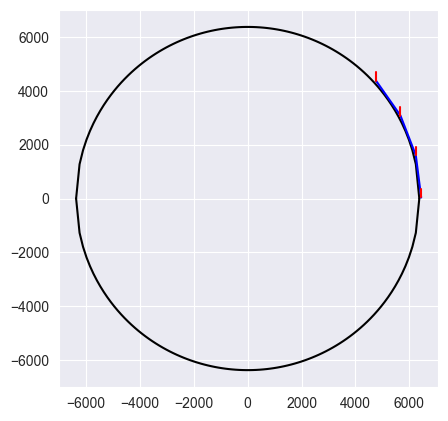

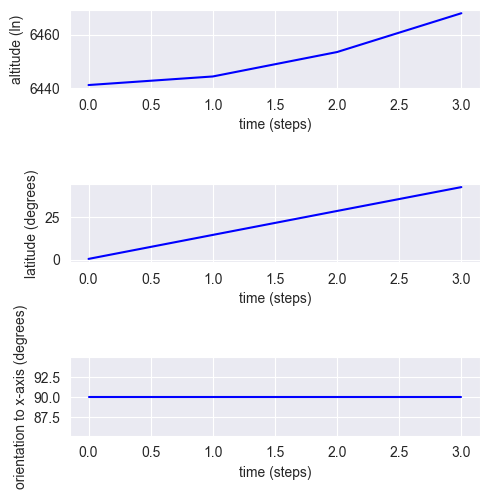

In [319]:
test_env.render(sample_traj_rate=40)

In [373]:
s = test_env.reset()

R = 0.0
t = 0.0
while True:
    t += 1
    a = [1.4, 0.005]
    if t > 10:
        a[1] = 0.0
    if t > 310:
        a = [0.0, 0.0]
    ns,r,d,_ = test_env.step(a)
    R += r
    if d:
        break

print('Reward: ', R)

fall
Reward:  297.2806557705195


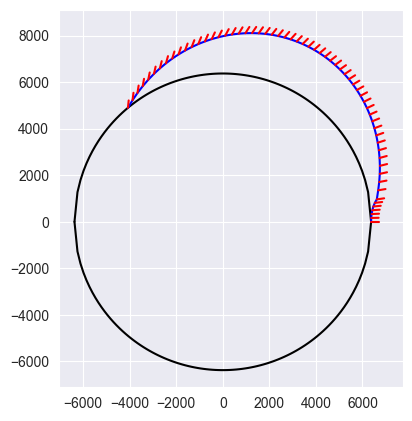

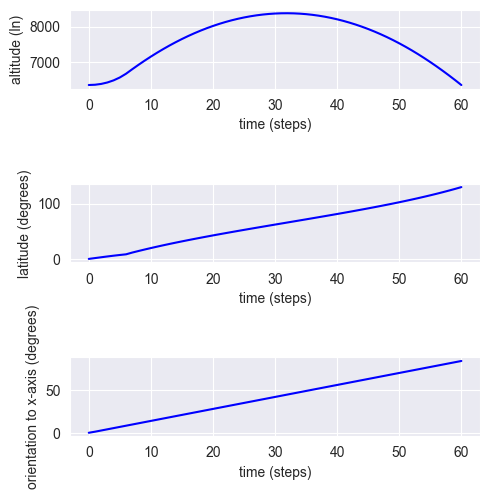

In [375]:
test_env.render(sample_traj_rate=10)

In [155]:
def test_net(net, env, count=10, device="cpu"):
    rewards = 0.0
    steps = 0
    for _ in range(count):
        obs = env.reset()
        while True:
            obs_v = ptan.agent.float32_preprocessor([obs]).to(device)
            mu_v = net(obs_v)
            action = mu_v.squeeze(dim=0).data.cpu().numpy()
            obs, reward, done, _ = env.step(action)
            rewards += reward
            steps += 1
            if done:
                break
    return rewards / count, steps / count

def unpack_batch_ddqn(batch, device="cpu"):
    states, actions, rewards, dones, last_states = [], [], [], [], []
    for exp in batch:
        states.append(exp.state)
        actions.append(exp.action)
        rewards.append(exp.reward)
        dones.append(exp.last_state is None)
        if exp.last_state is None:
            last_states.append(exp.state)
        else:
            last_states.append(exp.last_state)
    states_v = ptan.agent.float32_preprocessor(states).to(device)
    actions_v = ptan.agent.float32_preprocessor(actions).to(device)
    rewards_v = ptan.agent.float32_preprocessor(rewards).to(device)
    last_states_v = ptan.agent.float32_preprocessor(last_states).to(device)
    dones_t = torch.LongTensor(dones).to(device)
    return states_v, actions_v, rewards_v, dones_t, last_states_v


def distr_projection(next_distr_v, rewards_v, dones_mask_t, gamma, device="cpu"):
    next_distr = next_distr_v.data.cpu().numpy()
    rewards = rewards_v.data.cpu().numpy()
    dones_mask = dones_mask_t.cpu().numpy().astype(np.bool)
    batch_size = len(rewards)
    proj_distr = np.zeros((batch_size, N_ATOMS), dtype=np.float32)

    for atom in range(N_ATOMS):
        tz_j = np.minimum(Vmax, np.maximum(Vmin, rewards + (Vmin + atom * DELTA_Z) * gamma))
        b_j = (tz_j - Vmin) / DELTA_Z
        l = np.floor(b_j).astype(np.int64)
        u = np.ceil(b_j).astype(np.int64)
        eq_mask = u == l
        proj_distr[eq_mask, l[eq_mask]] += next_distr[eq_mask, atom]
        ne_mask = u != l
        proj_distr[ne_mask, l[ne_mask]] += next_distr[ne_mask, atom] * (u - b_j)[ne_mask]
        proj_distr[ne_mask, u[ne_mask]] += next_distr[ne_mask, atom] * (b_j - l)[ne_mask]

    if dones_mask.any():
        proj_distr[dones_mask] = 0.0
        tz_j = np.minimum(Vmax, np.maximum(Vmin, rewards[dones_mask]))
        b_j = (tz_j - Vmin) / DELTA_Z
        l = np.floor(b_j).astype(np.int64)
        u = np.ceil(b_j).astype(np.int64)
        eq_mask = u == l
        eq_dones = dones_mask.copy()
        eq_dones[dones_mask] = eq_mask
        if eq_dones.any():
            proj_distr[eq_dones, l[eq_mask]] = 1.0
        ne_mask = u != l
        ne_dones = dones_mask.copy()
        ne_dones[dones_mask] = ne_mask
        if ne_dones.any():
            proj_distr[ne_dones, l[ne_mask]] = (u - b_j)[ne_mask]
            proj_distr[ne_dones, u[ne_mask]] = (b_j - l)[ne_mask]
    return torch.FloatTensor(proj_distr).to(device)


HIDDEN_SIZE = 256

class DDPGActor(nn.Module):
    def __init__(self, obs_size, act_size):
        super(DDPGActor, self).__init__()

        self.thruster = nn.Sequential(
            nn.Linear(obs_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, 1)
        )
        
        self.rotation = nn.Sequential(
            nn.Linear(obs_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, 1)
        )
    
    def forward(self, x):
        thrust =  torch.sigmoid(self.thruster(x))*env.max_thrust
        rotation = torch.tanh(self.rotation(x))*env.max_o_thrust

        return torch.cat([thrust,rotation], dim=1)

class D4PGCritic(nn.Module):
    def __init__(self, obs_size, act_size, n_atoms, v_min, v_max):
        super(D4PGCritic, self).__init__()

        self.obs_net = nn.Sequential(
            nn.Linear(obs_size, 400),
            nn.ReLU(),
        )

        self.out_net = nn.Sequential(
            nn.Linear(400 + act_size, 300),
            nn.ReLU(),
            nn.Linear(300, n_atoms)
        )

        delta = (v_max - v_min) / (n_atoms - 1)
        self.register_buffer("supports", torch.arange(v_min, v_max + delta, delta))

    def forward(self, x, a):
        obs = self.obs_net(x)
        return self.out_net(torch.cat([obs, a], dim=1))

    def distr_to_q(self, distr):
        weights = F.softmax(distr, dim=1) * self.supports
        res = weights.sum(dim=1)
        return res.unsqueeze(dim=-1)
    
class AgentD4PG(ptan.agent.BaseAgent):
    """
    Agent implementing noisy agent
    """
    def __init__(self, net, device="cpu", epsilon=0.3):
        self.net = net
        self.device = device
        self.epsilon = epsilon

    def __call__(self, states, agent_states):
        states_v = ptan.agent.float32_preprocessor(states).to(self.device)
        mu_v = self.net(states_v)
        actions = mu_v.data.cpu().numpy()
        actions += self.epsilon * np.random.normal(size=actions.shape)
        return actions, agent_states

In [156]:
GAMMA = 0.99
BATCH_SIZE = 64

LEARNING_RATE = 1e-4

REPLAY_SIZE = 100000
REPLAY_INITIAL = 10000

REWARD_STEPS = 5

TEST_ITERS = 1000

Vmax = 10
Vmin = -1
N_ATOMS = 51
DELTA_Z = (Vmax - Vmin) / (N_ATOMS - 1)

In [157]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

act_net = DDPGActor(env.observation_space.shape[0], env.action_space.shape[0]).to(device)
crt_net = D4PGCritic(env.observation_space.shape[0], env.action_space.shape[0], N_ATOMS, Vmin, Vmax).to(device)

print(act_net)
print(crt_net)

tgt_act_net = ptan.agent.TargetNet(act_net)
tgt_crt_net = ptan.agent.TargetNet(crt_net)

agent = AgentD4PG(act_net, device=device)

exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=GAMMA, steps_count=REWARD_STEPS)
buffer = ptan.experience.ExperienceReplayBuffer(exp_source, buffer_size=REPLAY_SIZE)

act_opt = optim.Adam(act_net.parameters(), lr=LEARNING_RATE)
crt_opt = optim.Adam(crt_net.parameters(), lr=LEARNING_RATE)

DDPGActor(
  (thruster): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1, bias=True)
  )
  (rotation): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1, bias=True)
  )
)
D4PGCritic(
  (obs_net): Sequential(
    (0): Linear(in_features=4, out_features=400, bias=True)
    (1): ReLU()
  )
  (out_net): Sequential(
    (0): Linear(in_features=402, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=51, bias=True)
  )
)


In [150]:
frame_idx = 0
best_reward = None

while True:
    frame_idx += 1
    buffer.populate(1)

    if len(buffer) < REPLAY_INITIAL:
        continue

    batch = buffer.sample(BATCH_SIZE)
    states_v, actions_v, rewards_v, dones_mask, last_states_v = \
        unpack_batch_ddqn(batch, device)

    # train critic
    crt_opt.zero_grad()
    crt_distr_v = crt_net(states_v, actions_v)
    last_act_v = tgt_act_net.target_model(last_states_v)
    last_distr_v = F.softmax(tgt_crt_net.target_model(last_states_v, last_act_v), dim=1)
    proj_distr_v = distr_projection(last_distr_v, rewards_v, dones_mask,
                                    gamma=GAMMA**REWARD_STEPS)
    prob_dist_v = -F.log_softmax(crt_distr_v, dim=1) * proj_distr_v
    critic_loss_v = prob_dist_v.sum(dim=1).mean()
    critic_loss_v.backward()
    crt_opt.step()

    # train actor
    act_opt.zero_grad()
    cur_actions_v = act_net(states_v)
    crt_distr_v = crt_net(states_v, cur_actions_v)
    actor_loss_v = -crt_net.distr_to_q(crt_distr_v)
    actor_loss_v = actor_loss_v.mean()
    actor_loss_v.backward()
    act_opt.step()
    

    tgt_act_net.alpha_sync(alpha=1 - 1e-3)
    tgt_crt_net.alpha_sync(alpha=1 - 1e-3)

    if (frame_idx % TEST_ITERS) == 0:
        ts = time.time()
        rewards, steps = test_net(act_net, env, device=device)
        print("Test done in %.2f sec, avg reward %.6f, avg steps %d, frac of max %.5f" % 
              (time.time() - ts, rewards, steps, float(steps/env.max_steps)))

        if best_reward is None or best_reward < rewards:
            if best_reward is not None:
                print("Best reward updated: %.6f -> %.6f" % (best_reward, rewards))
                
            #agent.ou_sigma = np.clip((1.-1./1e6)*agent.ou_sigma, a_min=0.1, a_max=np.inf)
            best_reward = rewards
        
        if best_reward > 1e6:
            print('solved.')
            break

Test done in 0.01 sec, avg reward 0.006207, avg steps 1, frac of max 0.00011
Test done in 0.01 sec, avg reward 0.006207, avg steps 1, frac of max 0.00011


KeyboardInterrupt: 

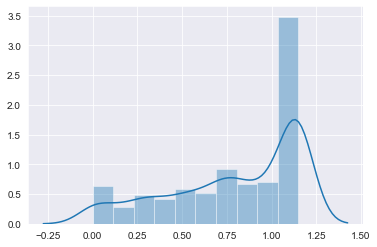

In [108]:
sns.distplot(actions_v[:,0].data.cpu().numpy())

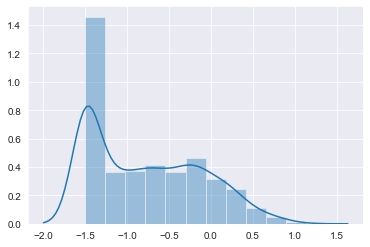

In [109]:
sns.distplot(actions_v[:,1].data.cpu().numpy())

In [110]:
s = test_env.reset()

traj_a = []
R = 0.0
while True:
    s_v = torch.FloatTensor([s]).to(device)
    a_v = act_net(s_v)
    a = a_v.data.cpu().numpy()[0]
    traj_a.append(a)
    s,r,d,_ = test_env.step(a)
    R += r
    if d:
        break

print(R)
traj_a = np.array(traj_a)

197.5911722464388


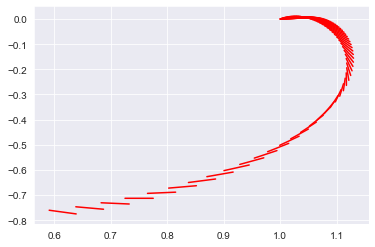

In [111]:
# orientation vector every Nth
xaxis_orientation = test_env.trajectory[:,2]
# vector terminal pts
start_pts = test_env.trajectory[:,[0,1]]
end_pts = start_pts + 0.05*np.dstack((np.cos(xaxis_orientation), np.sin(xaxis_orientation)))[0]


for idx in range(len(start_pts)):
    plt.plot([start_pts[idx,0],end_pts[idx,0]], [start_pts[idx,1],end_pts[idx,1]], c='r')
plt.show();

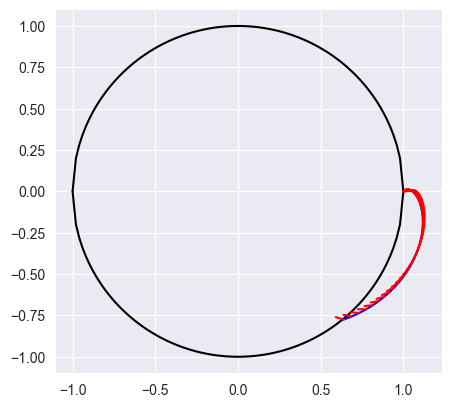

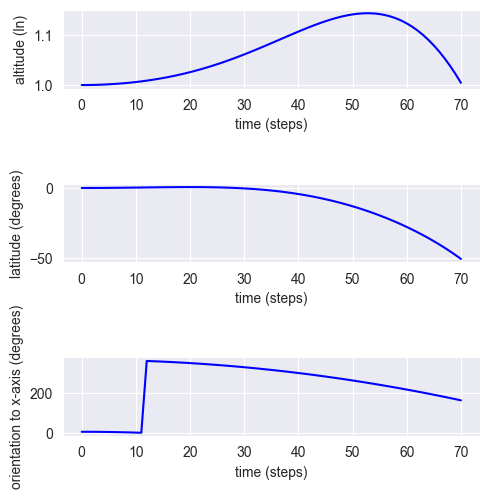

In [112]:
test_env.render(sample_traj_rate = 1)

In [101]:
traj_a[:,0]

array([0.63794976], dtype=float32)

In [102]:
traj_a[:,1]

array([0.5561695], dtype=float32)

In [73]:
many_traj = []
many_a = []

for _ in range(1):
    traj = []
    a_history = []
    
    s = test_env.reset()
    while True:
        traj.append(s)
    
        s_v = torch.FloatTensor([s]).to(device)
        a_v = act_net(s_v)
        a = a_v.data.cpu().numpy()[0]
        a_history.append( np.clip(a, -test_env.max_thrust, test_env.max_thrust))
    
        s,r,d,_ = test_env.step(a)
        if d:
            break

    many_traj.append(np.array(traj))
    many_a.append(np.array(a_history))

many_traj = np.array(many_traj)
many_a = np.array(many_a)

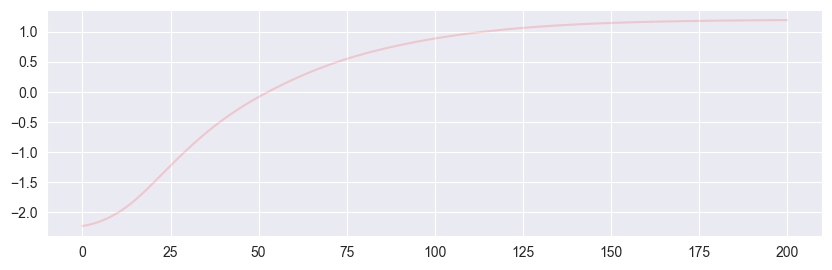

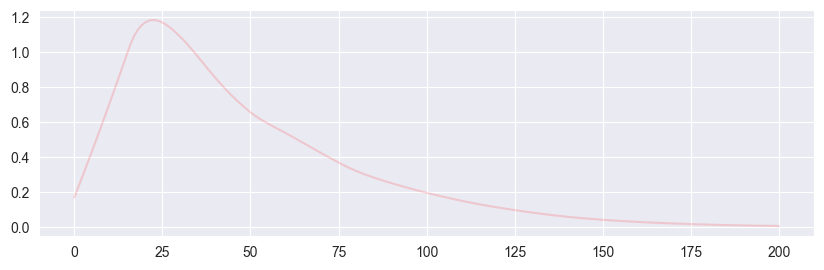

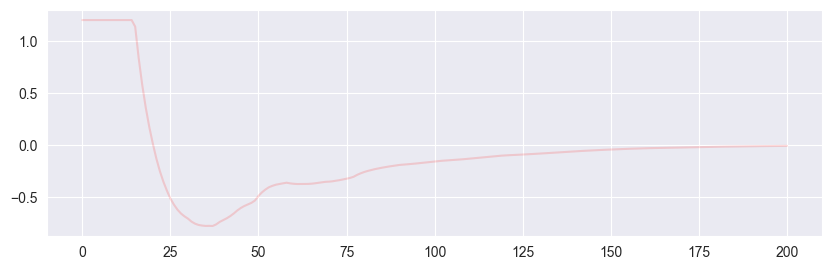

In [344]:
plt.figure(figsize=(10,3), dpi=100)
plt.plot(many_traj[:,:,0].T, color='r', alpha=0.15);
plt.show();

plt.figure(figsize=(10,3), dpi=100)
plt.plot(many_traj[:,:,1].T, color='r', alpha=0.15);
plt.show()

plt.figure(figsize=(10,3), dpi=100)
plt.plot(many_a[:,:,0].T, color='r', alpha=0.15);
plt.show()